# Utils

In [672]:
def embed_notes(tokens: List[List[str]], model):
    """Embed tokens with the given model."""
    return [[model[t] for t in note if t in model]
            for note in tokens]

# Read Data

In [646]:
import pandas as pd
from pyathena.util import as_pandas
from datetime import datetime
import numpy as np
import functools as ft
import os
from constants import TREE, PROJ_DIR
from typing import List, Set, Dict, Tuple
from utils import (get_conn, ICDDataset, group_v_roots, 
                   probs_to_preds, process_all_notes)
from icd9.icd9 import ICD9, Node

In [538]:
# read in raw data
subdir = "half_data_ids"
lim = 5000
ids = pd.read_csv(os.path.join(subdir, "ids.csv"), 
                  squeeze=True, nrows=lim).tolist()
raw_roots = pd.read_csv(os.path.join(subdir, "roots_labels.csv"), 
                        squeeze=True, nrows=lim).tolist()
doc2vec = pd.read_csv(os.path.join(subdir, "doc2vec.csv"), 
                         header=None, nrows=lim).values

In [539]:
# clean data
roots = [[s.strip("''") for s in x.strip("[]").split(", ") if len(s.strip("''")) > 0]
         for x in raw_roots]
roots = [group_v_roots(row) for row in roots]

# Exploratory Visualizations

In [623]:
from visdata import summary_table, note_lengths, icd_summary
import matplotlib.pyplot as plt
import seaborn as sns

## Summary Table

In [429]:
summary_table = pd.read_csv("data/full_summary.csv")

In [430]:
summary_table.columns = ["Category"] + list(summary_table.columns[1:])
summary_table = summary_table.set_index("Category")

In [435]:
summary_table.astype("int")

,Totals,Male,Medicare,Female,Private,Medicaid,Government,Self Pay
Category,,,,,,,,
Patients,46520,26121,21002,20399,19663,4570,1614,600
Admissions,58976,32950,28215,26026,22582,5785,1783,611
ICD9 Codes,11501,5852,5023,5649,5718,3989,2657,1467
Deaths,5836,3141,3903,2695,1372,381,90,95
Admissions Per Patient,1,1,1,1,1,1,1,1
ICD9 Codes Per Patient,0,0,0,0,0,0,1,2
ICD9 Codes Per Admission,0,0,0,0,0,0,1,2
Death Per Patient,0,0,0,0,0,0,0,0


In [432]:
icd_table = pd.read_csv("data/icd_summary.csv")

In [433]:
icd_table = icd_table.sort_values("Mimic-iii Counts", ascending=False)
icd_latex = icd_table.to_latex()

In [434]:
icd_table

,Code,Description,Mimic-iii Counts,Nodes in ICD Tree
2,390-459,DISEASES OF THE CIRCULATORY SYSTEM,124782,516
3,240-279,"ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES,...",52095,333
0,460-519,DISEASES OF THE RESPIRATORY SYSTEM,40989,277
11,800-999,INJURY AND POISONING,35518,1881
5,520-579,DISEASES OF THE DIGESTIVE SYSTEM,34595,625
1,580-629,DISEASES OF THE GENITOURINARY SYSTEM,32860,471
8,780-799,"SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS",28873,372
6,320-389,DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS,20397,1633
15,001-139,INFECTIOUS AND PARASITIC DISEASES,19507,1057
13,V10-V19,PERSONS WITH POTENTIAL HEALTH HAZARDS RELATED ...,18358,228


## Category Counts

In [36]:
ccounts_query = "select category, count(row_id) from mimiciii.noteevents group by category;"
ccounts_df = as_pandas(cursor.execute(ccounts_query))
ccounts_df.columns = ["category", "count"]
ccounts_df = ccounts_df.sort_values("count", ascending=False)

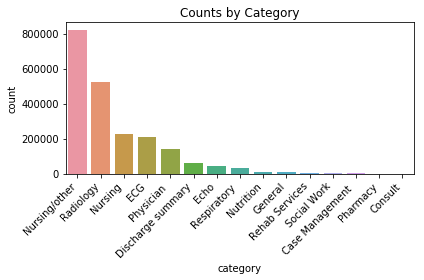

In [39]:
cat_fp = os.path.join(PROJ_DIR, "images", "categories.png")
ax = sns.barplot(x="category", y="count", data=ccounts_df)
ax.set_title("Counts by Category")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.tight_layout()
plt.savefig(cat_fp)
plt.show()

## Distribution of Word Counts in Notes

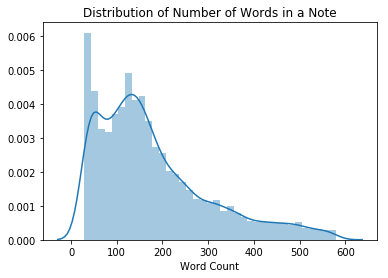

In [376]:
with get_conn() as conn:
    cursor = conn.cursor()
    notes = as_pandas(cursor.execute("select text from mimiciii.noteevents order by RAND() limit 10000;"))["text"]
lens = notes.apply(lambda x: len(x.split()))
no_outliers = lens[lens.between(lens.quantile(.1), lens.quantile(.9))]
ax = sns.distplot(no_outliers)
ax.set_title("Distribution of Number of Words in a Note")
ax.set_xlabel("Word Count")
plt.savefig("images/word_counts.png")
plt.show()

## ICD Codes by Insurance

In [413]:
# read data
with get_conn() as conn:
    cursor = conn.cursor()
    query = """
    select admissions.hadm_id as adm_id, count(diagnoses_icd.icd9_code) as icd, array_agg(admissions.insurance)[1] as insurance
    from mimiciii.admissions as admissions
    join mimiciii.diagnoses_icd as diagnoses_icd
    on admissions.hadm_id = diagnoses_icd.hadm_id
    group by admissions.hadm_id;
    """
    insur_icd_df = as_pandas(cursor.execute(query))

In [414]:
insur_icd_df.head()

,adm_id,icd,insurance
0,122211,14,Medicare
1,146127,7,Private
2,155989,5,Private
3,149699,8,Medicare
4,188343,17,Medicare


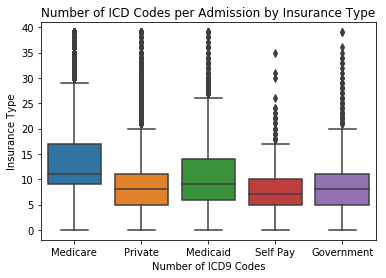

In [603]:
ax = sns.boxplot(x="insurance", y="icd", data=insur_icd_df)
ax.set(xlabel="Number of ICD9 Codes",
       ylabel="Insurance Type",
       title="Number of ICD Codes per Admission by Insurance Type")
plt.savefig("images/insurance.png")
plt.show()

# Preprocessing

In [642]:
# read in data
with get_conn() as conn:
    cursor = conn.cursor()
    query = f"""
    SELECT
      text
    FROM
      mimiciii.noteevents
    LIMIT 1000;
    """
    notes = as_pandas(cursor.execute(query))["text"].tolist()

In [647]:
# tokenize notes
tokens = process_all_notes(notes)

## Word2Vec

In [627]:
import gensim
from gensim.test.utils import datapath
from gensim.models import KeyedVectors

In [639]:
# load word2vec embeddings
w2v_fp = os.path.join(PROJ_DIR, "/GoogleNews-vectors-negative300.bin")
word2vec = KeyedVectors.load_word2vec_format(w2v_fp, binary=True)

In [673]:
# embed with word2vec
X_w2v = embed_notes(tokens, word2vec)

## BERT

In [651]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [656]:
model(torch.tensor(tokens[0]))

ValueError: too many dimensions 'str'

## Prepare Data

In [490]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [540]:
# prepare train/test data
mlb = MultiLabelBinarizer()
root_oh = mlb.fit_transform(roots)
class_names = mlb.classes_
X_train, X_test, Y_train, Y_test = train_test_split(doc2vec, root_oh, test_size=0.3)

# Models

## Baseline Models

In [470]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

In [541]:
# instantiate classifiers
clfs = {
    "LogisticRegression": OneVsRestClassifier(LogisticRegression(multi_class="ovr")),
    "RandomForest": OneVsRestClassifier(RandomForestClassifier(n_estimators=150, criterion="entropy")),
    "MultiLayerPerceptron": MLPClassifier(hidden_layer_sizes=(40, 30))
}

In [542]:
# train baseline classifiers
trained_clfs = {name: clf.fit(X_train, Y_train) for name, clf in clfs.items()}

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [407]:
class LSTM(nn.Module):
    """An LSTM implementation."""

    def __init__(self, n_feat, h_size, lstm_size, n_cat):
        super(LSTM, self).__init__()
        # define layers
        self.lstm = nn.LSTM(h_size, lstm_size, batch_first=True)
        self.h = nn.Linear(n_feat, h_size)
        self.out = nn.Linear(lstm_size, n_cat)
        self.sig = nn.Sigmoid()

    def forward(self, X):
        lstm = F.relu(self.lstm(X))
        hidden = F.relu(self.h(lstm))
        output = self.sig(self.out(hidden))
        return output
    
    def run_train(self, trainloader: DataLoader, n_epochs: int) -> None:
        """Train network on training set."""
        self.train()  # set model to train mode
        loss_fn = nn.BCELoss(reduction='mean')
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        # loop over the dataset for each epoch
        print("Training mlp .....")
        for i in range(n_epochs):
            print(f"\tEpoch {i}:", end=" ")
            for data in trainloader:
                # extracts features/labels from loader
                feats, labels = data

                # zero the parameter gradients
                optimizer.zero_grad()

                # retrieve outputs
                breakpoint()
                outputs = self.forward(feats.unsqueeze(0))
                
                # determine loss and backprop
                loss = loss_fn(outputs, labels)
                loss.backward()  # calculate gradients
                optimizer.step()  # update parameters
                
            print(f"loss = {loss}")
        print("done.")

In [405]:
# declare train and test loaders
BATCH_SIZE = 64
trainset = ICDDataset(emb_train, np.array(Y_train))
testset = ICDDataset(X_test, np.array(Y_test))
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = DataLoader(testset, shuffle=False)

In [408]:
# train MLP
n_epochs = 30
n_feats = trainset.X.shape[1]
n_cats = len(top_level_roots)
lstm = LSTM(n_feats, 50, 35, n_cats)
lstm.run_train(trainloader, n_epochs)

Training mlp .....
	Epoch 0: > <ipython-input-407-63de4d7b9305>(36)run_train()
-> outputs = self.forward(feats.unsqueeze(0))


(Pdb)  feats


tensor([[-0.6701, -0.4250,  0.2361,  ...,  0.1179, -0.1573,  0.0930],
        [-2.6161, -0.3542, -0.1131,  ...,  0.6816, -0.5644,  0.8088],
        [-0.8327, -0.2718,  0.3239,  ..., -0.3349,  0.0167, -0.0646],
        ...,
        [ 0.2721, -0.6895, -0.2552,  ...,  0.2014, -2.1652,  2.1458],
        [-1.1545, -1.2734,  0.7485,  ..., -2.3777, -0.7547,  0.1417],
        [-0.8845, -0.5813,  0.4892,  ..., -0.2053, -0.6622,  0.1400]])


(Pdb)  feats.shape


torch.Size([64, 50])
--KeyboardInterrupt--


(Pdb)  quit()


Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


BdbQuit: 

(Pdb)  quit()


# Results

In [543]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, precision_recall_curve)

In [544]:
# store prediction and probability results
pred_clfs = {name: clf.predict(X_test) for name, clf in trained_clfs.items()}
prob_clfs = {name: clf.predict_proba(X_test) for name, clf in trained_clfs.items()}

## Performance Results

In [609]:
# get performance data
f1s = [f1_score(Y_test, preds, average="weighted", zero_division=1) for preds in pred_clfs.values()]
accs = [accuracy_score(Y_test, preds) for preds in pred_clfs.values()]
metrics = f1s + accs
met_labels = ["F1 Score"] * len(pred_clfs) + ["Accuracy"] * len(pred_clfs)
clf_names = list(pred_clfs.keys()) * 2

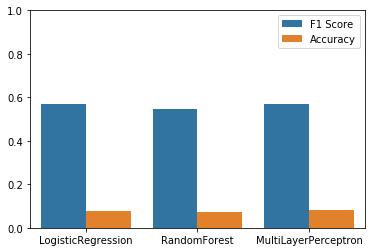

In [611]:
ax = sns.barplot(x=clf_names, y=metrics, hue=met_labels)
ax.set_ylim([0, 1])
plt.show()

## Classification Reports

In [550]:
class_reports = {name: classification_report(Y_test, Y_pred, target_names=class_names, 
                                             zero_division=1, output_dict=True)
                 for name, Y_pred in pred_clfs.items()}
crep_dfs = {name: pd.DataFrame(crep).T for name, crep in class_reports.items()}
crep_df = pd.concat(crep_dfs, axis=1)

In [602]:
crep_df

LogisticRegression                              \
                       f1-score precision    recall support   
001-139                0.444172  0.595395  0.354207   511.0   
140-239                0.125604  0.565217  0.070652   184.0   
240-279                0.671132  0.677943  0.664456   754.0   
290-319                0.175637  0.413333  0.111511   278.0   
320-389                0.254181  0.550725  0.165217   460.0   
390-459                0.867593  0.821209  0.919529  1019.0   
460-519                0.749237  0.732697  0.766542   801.0   
520-579                0.466523  0.605042  0.379613   569.0   
580-629                0.602263  0.647940  0.562602   615.0   
680-709                0.033898  0.333333  0.017857   224.0   
710-739                0.033898  0.333333  0.017857   168.0   
760-779                0.828660  0.852564  0.806061   330.0   
780-799                0.488000  0.563510  0.430335   567.0   
800-999                0.545607  0.595978  0.503086   648.0   
V01-V91                0.670866  0.579329  0.796758   802.0   
micro avg              0.606692  0.669764  0.554477  7930.0   
macro avg              0.463818  0.591170  0.437752  7930.0   
weighted avg           0.567081  0.635113  0.554477  7930.0   
samples avg            0.580279  0.681408  0.575893  7930.0   

             MultiLayerPerceptron                             RandomForest  \
                         f1-score precision    recall support     f1-score   
001-139                  0.463470  0.556164  0.397260   511.0     0.359942   
140-239                  0.184211  0.477273  0.114130   184.0     0.000000   
240-279                  0.681529  0.655637  0.709549   754.0     0.691204   
290-319                  0.153453  0.265487  0.107914   278.0     0.055556   
320-389                  0.287926  0.500000  0.202174   460.0     0.188324   
390-459                  0.866635  0.828265  0.908734  1019.0     0.880469   
460-519                  0.726161  0.711377  0.741573   801.0     0.747967   
520-579                  0.459259  0.577128  0.381371   569.0     0.418549   
580-629                  0.600993  0.612142  0.590244   615.0     0.585069   
680-709                  0.097015  0.295455  0.058036   224.0     0.000000   
710-739                  0.074468  0.350000  0.041667   168.0     0.000000   
760-779                  0.856260  0.873817  0.839394   330.0     0.846154   
780-799                  0.481262  0.545861  0.430335   567.0     0.460385   
800-999                  0.562450  0.588533  0.538580   648.0     0.562756   
V01-V91                  0.637088  0.585774  0.698254   802.0     0.674110   
micro avg                0.600827  0.649568  0.558890  7930.0     0.605431   
macro avg                0.475479  0.561527  0.450614  7930.0     0.431366   
weighted avg             0.570049  0.613222  0.558890  7930.0     0.548176   
samples avg              0.578930  0.679067  0.584408  7930.0     0.582822   

                                          
             precision    recall support  
001-139       0.696629  0.242661   511.0  
140-239       1.000000  0.000000   184.0  
240-279       0.652532  0.734748   754.0  
290-319       0.800000  0.028777   278.0  
320-389       0.704225  0.108696   460.0  
390-459       0.814691  0.957802  1019.0  
460-519       0.699240  0.803995   801.0  
520-579       0.647059  0.309315   569.0  
580-629       0.627561  0.547967   615.0  
680-709       1.000000  0.000000   224.0  
710-739       1.000000  0.000000   168.0  
760-779       0.944030  0.766667   330.0  
780-799       0.585831  0.379189   567.0  
800-999       0.600701  0.529321   648.0  
V01-V91       0.587581  0.790524   802.0  
micro avg     0.682487  0.544010  7930.0  
macro avg     0.757339  0.413311  7930.0  
weighted avg  0.708563  0.544010  7930.0  
samples avg   0.689478  0.567828  7930.0

## Probability Distributions

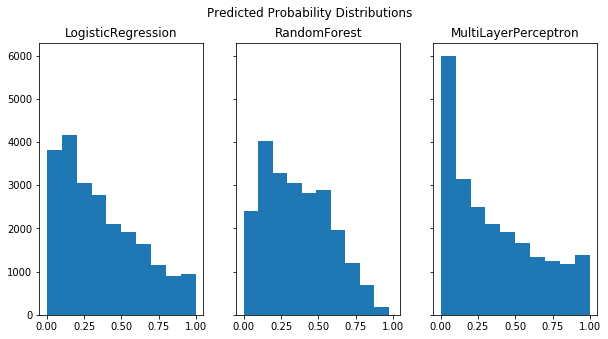

In [619]:
fig, axs = plt.subplots(1, len(prob_clfs), sharey="all", sharex="all")
for ax, name, probs in zip(axs, prob_clfs.keys(), prob_clfs.values()):
    ax.hist(probs.flatten())
    ax.set(title=name)
fig.set_size_inches(10, 5)
fig.suptitle("Predicted Probability Distributions")
plt.show()

## Precision/Recall Curves

In [584]:
def pr_curve(clf_name, probs, y_true, thresholds):
    """
    Generate precision/recall curve data for a given classifier.

    Implementation is custom because sklearn doesn't
    support multilabel classification for pr curve.
    """
    precs = []
    recs = []
    for thresh in thresholds:
        preds = probs_to_preds(probs, thresh)
        precs.append(precision_score(y_true, preds, average="weighted", zero_division=1))
        recs.append(recall_score(y_true, preds, average="weighted", zero_division=1))
    data = {"Classifier": [clf_name] * len(thresholds),
            "Precision": precs, 
            "Recall": recs, 
            "Threshold": thresholds}
    return pd.DataFrame(data)

In [597]:
# extract precision/recall data across thresholds
thresholds = np.linspace(0, 1, 100)
pr_dfs = [pr_curve(name, probs, Y_test, thresholds) for name, probs in prob_clfs.items()]
pr_df = pd.concat(pr_dfs)

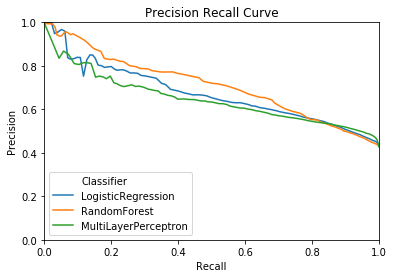

In [601]:
# plot precision recall curve for each classifier
ax = sns.lineplot(x="Recall", y="Precision", hue="Classifier", data=pr_df)
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set(title="Precision Recall Curve")
plt.show()

## Category Performance

In [366]:
# read in data
with get_conn() as conn:
    cursor = conn.cursor()
    query = f"""
    SELECT
      row_id as row_id,
      category
    FROM
      mimiciii.noteevents;
    """
    cat_df = as_pandas(cursor.execute(query))

In [377]:
cat_df.head()

,row_id,category
0,20030,Discharge summary
1,20031,Discharge summary
2,20032,Discharge summary
3,20033,Discharge summary
4,20034,Discharge summary


In [ ]:
merged_df = cat_df.merge(pd.DataFrame({"accaccs))